In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

Загрузим датасет

In [47]:
df = pd.read_csv('dataset.csv', header=0, infer_datetime_format=True, 
                 parse_dates=['course_finished_date'], 
                 index_col=['course_finished_date'])

Еще раз визуализируем ряд для удобства

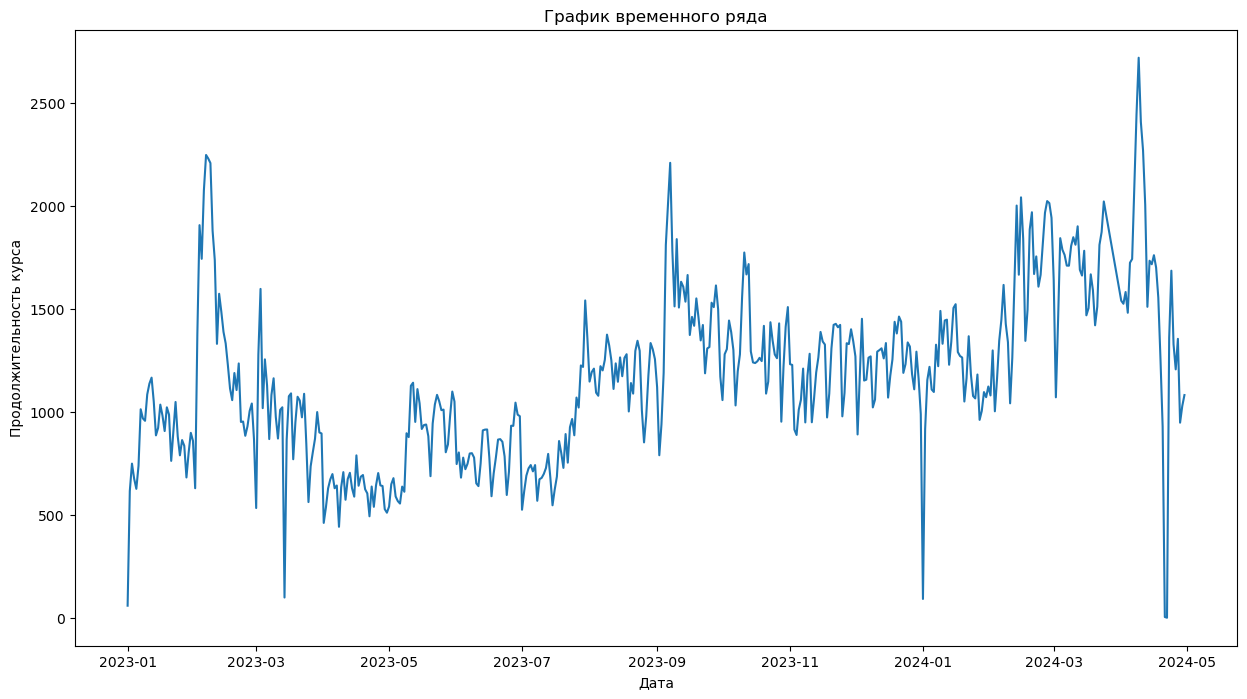

In [48]:
plt.figure(figsize=(15,8))
plt.plot(df['course_duration_sum'])
plt.title('График временного ряда')
plt.xlabel('Дата')
plt.ylabel('Продолжительность курса')
plt.show()

Проверим ряд на стационарность

In [49]:
def stat_detection(dataset):
    print('Результат теста:')
    df_result = adfuller(dataset)
    df_labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for result_value, label in zip(df_result, df_labels):
        print(label + ' : ' + str(result_value))

    if df_result[1] <= 0.05:
        print("Сильные доказательства против нулевой гипотезы, ряд является стационарным.")
    else:
        print("Слабые доказательства против нулевой гипотезы, ряд не является стационарным.")

Выделим целевой признак

In [50]:
duration = df.course_duration_sum
duration.head()

course_finished_date
2023-01-01     59.96
2023-01-02    616.06
2023-01-03    749.02
2023-01-04    675.80
2023-01-05    626.75
Name: course_duration_sum, dtype: float64

<Axes: >

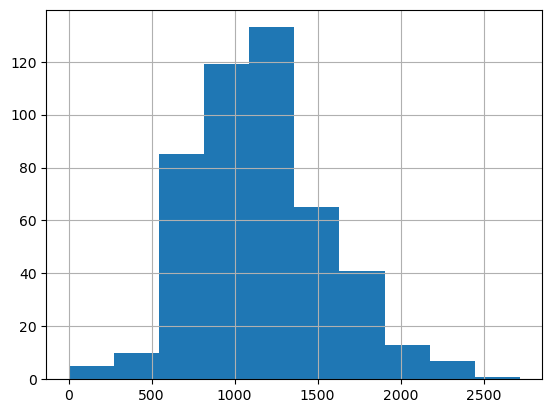

In [51]:
df.course_duration_sum.hist()

Как можно заметить из характеристик и гистограммы, ряд у нас более менее однородный и имеет относительно небольшой разброс. Для того, чтобы убедиться в этом проверим коэффициент вариации:

In [52]:
itog = duration.describe()
print('V = %f' % (itog['std']/itog['mean']))

V = 0.348380


Проверим ряд на стационарность:

In [53]:
stat_detection(duration)

Результат теста:
ADF Test Statistic : -2.2628695837523036
p-value : 0.18422295691155682
#Lags Used : 17
Number of Observations Used : 461
Слабые доказательства против нулевой гипотезы, ряд не является стационарным.


Определим порядок интегрированного ряда для нашего ряда:

In [54]:
duration1diff = duration.diff(periods=1).dropna()

In [55]:
stat_detection(duration1diff)

Результат теста:
ADF Test Statistic : -7.674387010343513
p-value : 1.5628149903316975e-11
#Lags Used : 16
Number of Observations Used : 461
Сильные доказательства против нулевой гипотезы, ряд является стационарным.


<Axes: xlabel='course_finished_date'>

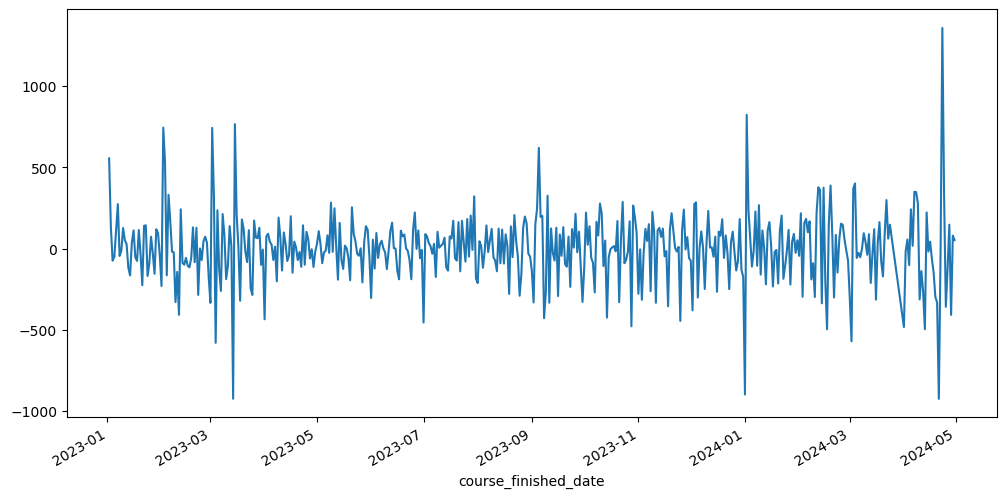

In [56]:
duration1diff.plot(figsize=(12,6))

## Построение модели временного ряда


Для моделирования будем использовать модель ARIMA, построенную для ряда первых разностей.
Итак, чтобы построить модель нам нужно знать ее порядок, состоящий из 2-х параметров:

p — порядок компоненты AR

d — порядок интегрированного ряда

q — порядок компонетны MA

Параметр d есть и он равет 1, Для  определения p и q нам надо изучить авторкорреляционную(ACF) и частично автокорреляционную(PACF) функции для ряда первых разностей.
ACF поможет нам определить q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA
PACF поможет нам определить p, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.
Чтобы построить соответствующие коррелограммы, в пакете statsmodels имеются следующие функции: plot_acf() и plot_pacf(). Они выводят графики ACF и PACF, у которых по оси X откладываются номера лагов, а по оси Y значения соответствующих функций. Нужно отметить, что количество лагов в функциях и определяет число значимых коэффициентов. Итак, наши функции выглядят так:
https://habr.com/ru/articles/207160/

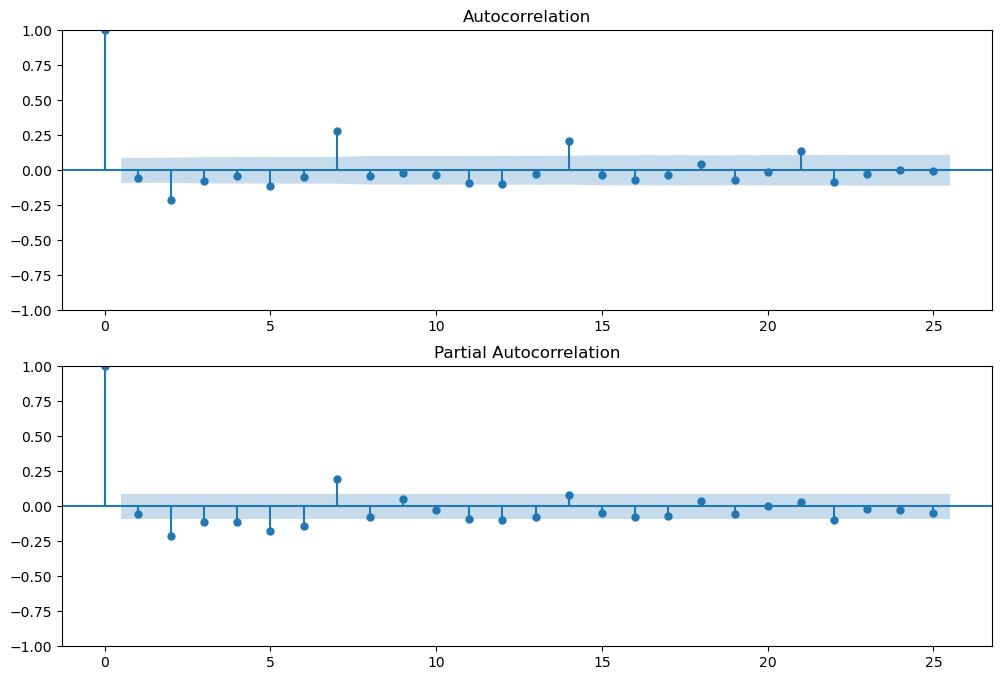

In [57]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(duration1diff.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(duration1diff, lags=25, ax=ax2)

В обоих случаях мы видим, что только один лаг резко отличается от 0, в таком случае и p и q будут равны 1

Поделим выборку на две части:


In [58]:
train = df['course_duration_sum'][:'2023-12-31']
test = df['course_duration_sum']['2024-01-01':'2024-03-24']

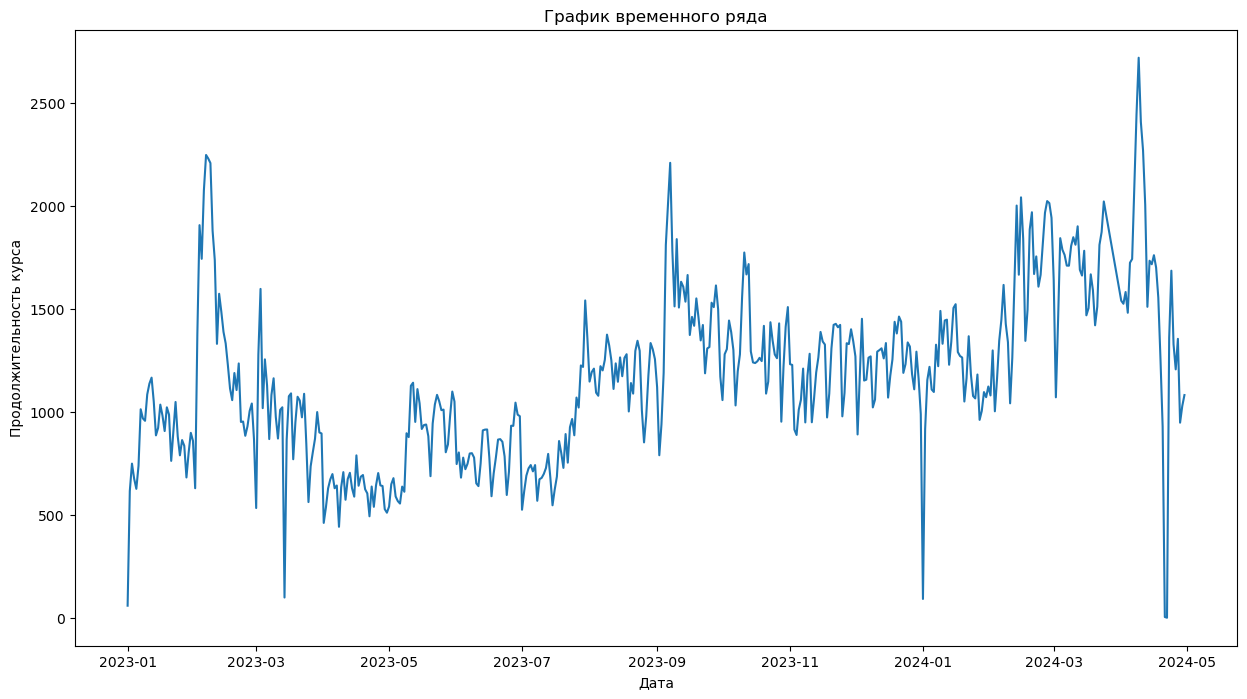

In [59]:
plt.figure(figsize=(15,8))
plt.plot(df['course_duration_sum'])
plt.title('График временного ряда')
plt.xlabel('Дата')
plt.ylabel('Продолжительность курса')
plt.show()

In [60]:
model = ARIMA(train, order=(3,1,4), freq='D')

In [61]:
result = model.fit()


In [62]:
print(result.summary())

                                SARIMAX Results                                
Dep. Variable:     course_duration_sum   No. Observations:                  365
Model:                  ARIMA(3, 1, 4)   Log Likelihood               -2386.104
Date:                 Tue, 18 Jun 2024   AIC                           4788.208
Time:                         18:10:12   BIC                           4819.385
Sample:                     01-01-2023   HQIC                          4800.599
                          - 12-31-2023                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3485      0.074      4.706      0.000       0.203       0.494
ar.L2         -0.6534      0.037    -17.882      0.000      -0.725      -0.582
ar.L3          0.7590      0.075     10.129 

In [63]:
# тестовый прогнозный период начнется с конца обучающего периода
start = len(train)
 
# и закончится в конце тестового
end = len(train) + len(test) - 1
  
# применим метод predict
predictions = result.predict(start, end)
predictions


2024-01-01    1139.739513
2024-01-02    1096.764267
2024-01-03    1034.104429
2024-01-04    1164.739996
2024-01-05    1218.593723
                 ...     
2024-03-20    1165.913689
2024-03-21    1190.184870
2024-03-22    1241.367231
2024-03-23    1195.808197
2024-03-24    1164.910001
Freq: D, Name: predicted_mean, Length: 84, dtype: float64

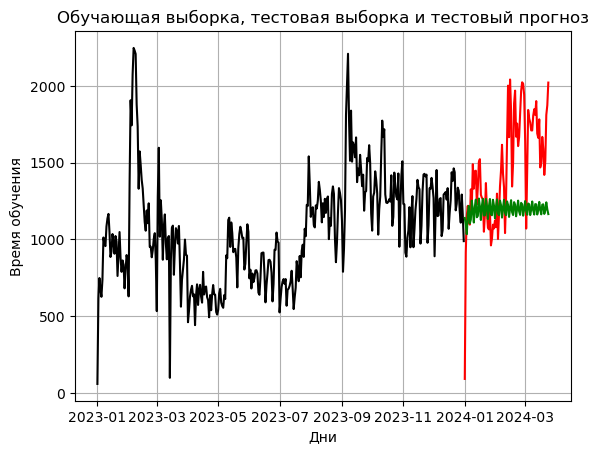

In [64]:
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(predictions, color = "green")
 
# заголовок и подписи к осям
plt.title("Обучающая выборка, тестовая выборка и тестовый прогноз")
plt.ylabel('Время обучения')
plt.xlabel('Дни')
 
# добавим сетку
plt.grid()
 
plt.show()

In [65]:
# Оценка качества модели
mse = mean_squared_error(test, predictions)
print('RMSE:', mse**0.5)

RMSE: 431.11913305161454


# SARIMAX

In [ ]:
# Функция для градиентного спуска
def search_optimal_sarima(df, seasonal_cycle):
    order_vals = diff_vals = ma_vals = range(1, 3)
    pdq_combinations = list(itertools.product(order_vals, diff_vals, ma_vals))
    seasonal_combinations = [(combo[0], combo[1], combo[2], seasonal_cycle) for combo in pdq_combinations]
    
    smallest_aic = float("inf")
    optimal_order_param = optimal_seasonal_param = None

    for order_param in pdq_combinations:
        for seasonal_param in seasonal_combinations:
            try:
                sarima_model = sm.tsa.statespace.SARIMAX(df,
                                                         order=order_param,
                                                         seasonal_order=seasonal_param,
                                                         enforce_stationarity=False,
                                                         enforce_invertibility=False)
                model_results = sarima_model.fit()
                if model_results.aic < smallest_aic:
                    smallest_aic = model_results.aic
                    optimal_order_param = order_param
                    optimal_seasonal_param = seasonal_param
                    print('ARIMA{}x{} - AIC:{}'.format(optimal_order_param, optimal_seasonal_param, smallest_aic))
            except:
                continue

    print('ARIMA{}x{} - AIC:{}'.format(optimal_order_param, optimal_seasonal_param, smallest_aic))

seasonal_cycle_length = 52
search_optimal_sarima(df.course_duration_sum, seasonal_cycle_length)

In [21]:
model = SARIMAX(train, order=(3,0,1), seasonal_order=(1, 2, 2, 52))

In [22]:
results = model.fit(disp=0)

In [23]:
# тестовый прогнозный период начнется с конца обучающего периода
start = len(train)
 
# и закончится в конце тестового
end = len(train) + len(test) - 1
# применим метод predict
predictions = results.predict(start, end)


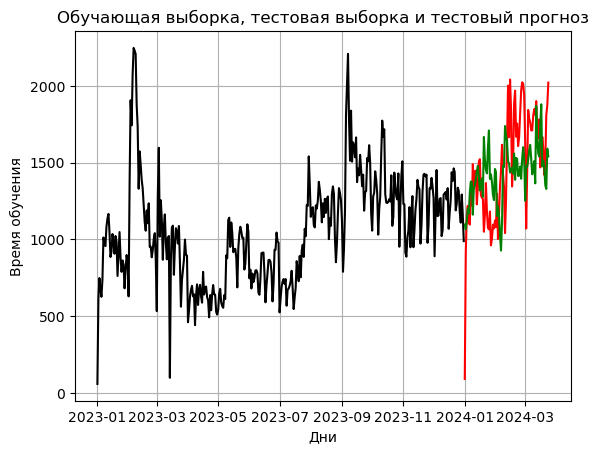

In [24]:
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(predictions, color = "green")
 
# заголовок и подписи к осям
plt.title("Обучающая выборка, тестовая выборка и тестовый прогноз")
plt.ylabel('Время обучения')
plt.xlabel('Дни')
 
# добавим сетку
plt.grid()
 
plt.show()

In [25]:
# Прогнозирование на 7 дней
forecast_horizon = 7  # Прогноз на 7 дней вперед
forecast = results.forecast(steps=forecast_horizon)

In [29]:
print(results.summary())

                                        SARIMAX Results                                        
Dep. Variable:                     course_duration_sum   No. Observations:                  365
Model:             SARIMAX(3, 0, 1)x(1, 2, [1, 2], 52)   Log Likelihood               -1847.425
Date:                                 Mon, 17 Jun 2024   AIC                           3710.851
Time:                                         19:13:14   BIC                           3739.367
Sample:                                     01-01-2023   HQIC                          3722.313
                                          - 12-31-2023                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7733      0.199      8.912      0.000       1.383       2

In [ ]:
# Функция для градиентного спуска
def search_optimal_sarima(df, seasonal_cycle):
    order_vals = diff_vals = ma_vals = range(1, 3)
    pdq_combinations = list(itertools.product(order_vals, diff_vals, ma_vals))
    seasonal_combinations = [(combo[0], combo[1], combo[2], seasonal_cycle) for combo in pdq_combinations]
    
    smallest_aic = float("inf")
    optimal_order_param = optimal_seasonal_param = None

    for order_param in pdq_combinations:
        for seasonal_param in seasonal_combinations:
            try:
                sarima_model = sm.tsa.statespace.SARIMAX(df,
                                                         order=order_param,
                                                         seasonal_order=seasonal_param,
                                                         enforce_stationarity=False,
                                                         enforce_invertibility=False)
                model_results = sarima_model.fit()
                if model_results.aic < smallest_aic:
                    smallest_aic = model_results.aic
                    optimal_order_param = order_param
                    optimal_seasonal_param = seasonal_param
            except:
                continue

    print('ARIMA{}x{} - AIC:{}'.format(optimal_order_param, optimal_seasonal_param, smallest_aic))

seasonal_cycle_length = 7
search_optimal_sarima(df.course_duration_sum, seasonal_cycle_length)

In [66]:
train = df['course_duration_sum'][:'2023-12-31']
test = df['course_duration_sum']['2024-01-01':"2024-03-26"]

In [67]:
model = SARIMAX(train, order=(3,0,1), seasonal_order=(1, 2, 2, 52))

In [68]:
results = model.fit(disp=0)

In [69]:
# тестовый прогнозный период начнется с конца обучающего периода
start = len(train)
 
# и закончится в конце тестового
end = len(train) + len(test) - 1
# применим метод predict
predictions = results.predict(start, end)

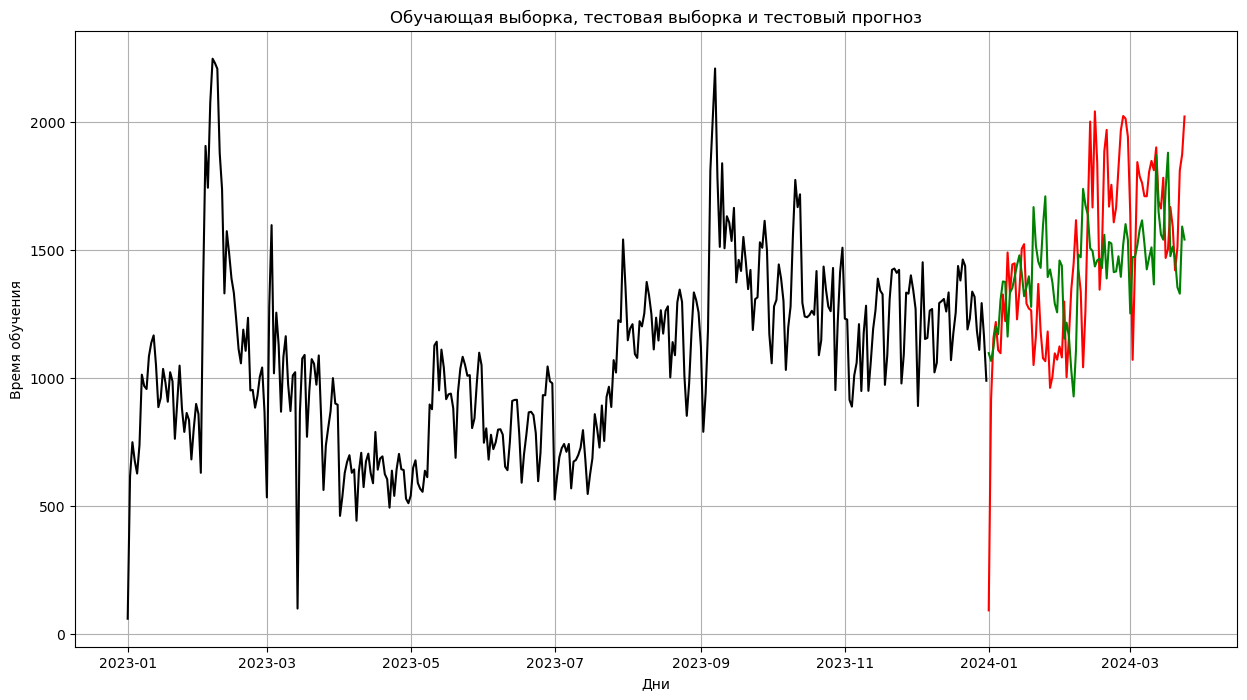

In [70]:
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.figure(figsize=(15,8))
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(predictions, color = "green")


 
# заголовок и подписи к осям
plt.title("Обучающая выборка, тестовая выборка и тестовый прогноз")
plt.ylabel('Время обучения')
plt.xlabel('Дни')
 
# добавим сетку
plt.grid()
 
plt.show()

In [71]:
# Оценка качества модели
mse = mean_squared_error(test, predictions)
print('RMSE:', mse**0.5)

RMSE: 328.3421646317428
